In [4]:
from functions_py import *
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy.ma as ma
import pandas as pd 
# import cv2
import skimage as sk
from array import array

def gaussian(x, a, mean, sigma):
    return a * np.exp(-((x - mean)**2 / (2 * sigma**2)))

# def Gaussian2(x,m1,s1,g1,a1, m2, s2, g2, a2): #data, mean, sigma, gain, height1, heigth2
#     return a1*np.exp(-1/2*((x-m1-g1)/s1)**2) + a2*np.exp(-1/2*((x-m2-g2)/s2)**2)

def Gaussian2(x,m,s,g,a1,a2): #data, mean, sigma, gain, height1, heigth2
    return a1*np.exp(-1/2*((x-m)/s)**2)+a2*np.exp(-1/2*((x-m-g)/s)**2)


def EnergySpectrum(x, N):
    return N * np.sin(x)*np.cos(x)**3

In [5]:
plt.rcParams.update({
    "image.origin": "lower",
    "image.aspect": 1,
    #"text.usetex": True,
    "grid.alpha": .5,
    "axes.linewidth":2,
    "lines.linewidth" : 1,
    "font.size":    15.0,
    "xaxis.labellocation": 'right',  # alignment of the xaxis label: {left, right, center}
    "yaxis.labellocation": 'top',  # alignment of the yaxis label: {bottom, top, center}
    "xtick.top":           True ,  # draw ticks on the top side
    "xtick.major.size":    8    ,# major tick size in points
    "xtick.minor.size":    4      ,# minor tick size in points
    "xtick.direction":     'in',
    "xtick.minor.visible": True,
    "ytick.right":           True ,  # draw ticks on the top side
    "ytick.major.size":    8    ,# major tick size in points
    "ytick.minor.size":    4      ,# minor tick size in points
    "ytick.direction":     'in',
    "ytick.minor.visible": True,
    "ytick.major.width":   2   , # major tick width in points
    "ytick.minor.width":   1 ,
    "xtick.major.width":   2   , # major tick width in points
    "xtick.minor.width":   1 ,
    "legend.framealpha": 0 ,
    "legend.loc": 'best',

})

Filename: /home/labdet/Documents/MauSan/imagenesMicrochip/01NOV23/proc_skp_m-009_microchip_T_170__Vv82_NSAMP_324_NROW_400_NCOL_700_EXPOSURE_0_NBINROW_1_NBINCOL_1_img_32.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     165   (700, 400)   float32   
  1                1 ImageHDU       164   (700, 400)   float32   
  2                1 ImageHDU       164   (700, 400)   float32   
  3                1 ImageHDU       164   (700, 400)   float32   


None
----------------


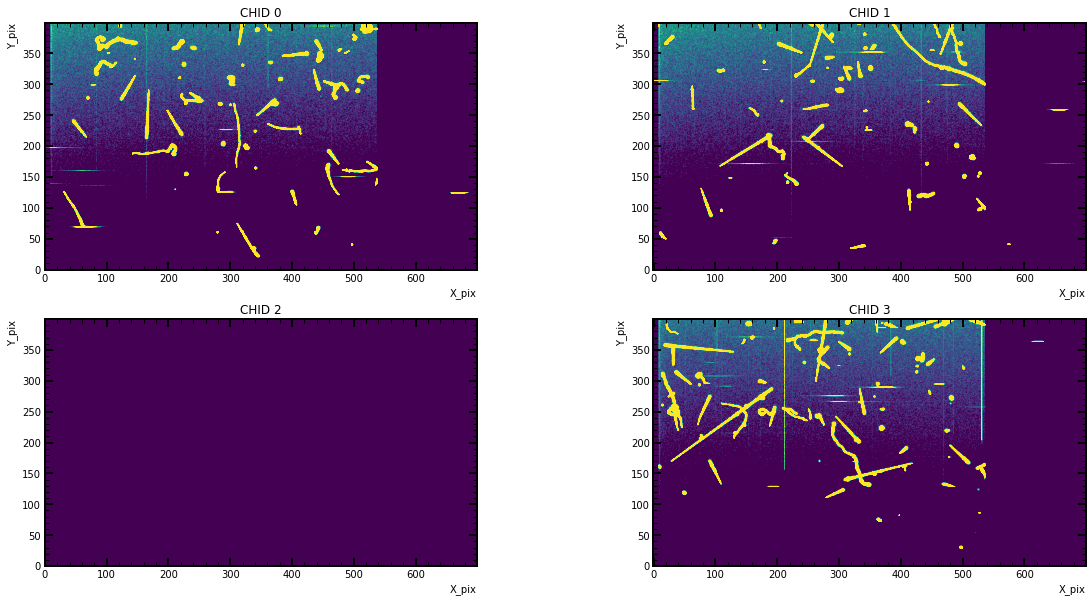

In [6]:
# path = '/home/labdet/Documents/MauSan/imagenesMicrochip/05JUN2023/proc_skp_m_009_microchip_vtested_T_170_seq_NSAMP_324_NROW_100_NCOL.fits'
# path = '/home/labdet/Documents/MauSan/imagenesMicrochip/17OCT23/am241_gammas/proc_skp_m-009_microchip_T_170__Vv82_NSAMP_324_NROW_50_NCOL_700_EXPOSURE_0_NBINROW_1_NBINCOL_1_img_690.fits'
# path = '/home/labdet/Documents/MauSan/imagenesMicrochip/05JUN2023/proc_skp_m_009_microchip_vtested_T_170_seq_NSAMP_225_NROW_100_NCOL.fits'
# path = '/home/labdet/Documents/MauSan/imagenesMicrochip/05JUN2023/proc_skp_m_009_microchip_vtested_T_170_seq_NSAMP_144_NROW_100_NCOL.fits'
# path = '/home/labdet/Documents/MauSan/imagenesMicrochip/01NOV23/proc_skp_m-009_microchip_T_170__Vv82_NSAMP_324_NROW_60_NCOL_700_EXPOSURE_0_NBINROW_1_NBINCOL_1_img_2.fits'
path = '/home/labdet/Documents/MauSan/imagenesMicrochip/01NOV23/proc_skp_m-009_microchip_T_170__Vv82_NSAMP_324_NROW_400_NCOL_700_EXPOSURE_0_NBINROW_1_NBINCOL_1_img_32.fits'


## DIRECCIONES DE COMPUTADORA DE CASA 
# path = '/home/bruce/Documents/imagenesMicrochip/proc_skp_m-009_microchip_T_170__Vv82_NSAMP_324_NROW_400_NCOL_700_EXPOSURE_0_NBINROW_1_NBINCOL_1_img_25.fits'
# path = '/home/bruce/Documents/imagenesMicrochip/ENE24/proc_skp_m-009_microchip_T_170__Vv82_NSAMP_324_NROW_400_NCOL_700_EXPOSURE_0_NBINROW_1_NBINCOL_1_img_62.fits'


hdu_list = fits.open(path)
print(hdu_list.info())
print('----------------')
# hdu_list[0].header
plt.figure(figsize=(20,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(hdu_list[i].data-np.median(hdu_list[i].data),vmin=1000,vmax=10000)
    plt.title('CHID '+str(i))
    plt.ylabel('Y_pix')
    plt.xlabel('X_pix')
plt.show()

# Sustrayendo el promedio por renglón

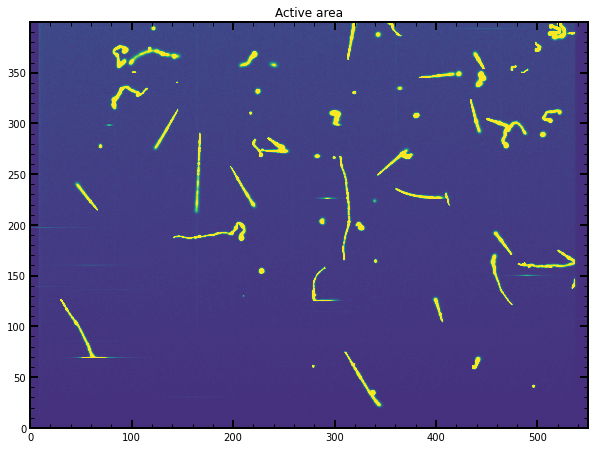

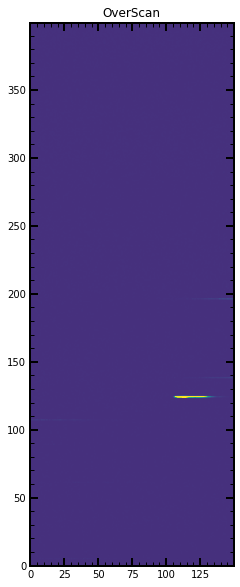

In [7]:
### Muestra el area activa y overscan de la extensión 

extension = 1
# plt.imshow(hdu_list[0].data[:, 550:], vmin = 0, vmax = 80000, origin = 'lower')
Overscan = hdu_list[extension - 1].data[:, 550:]
active_area = hdu_list[extension - 1].data[:, :550]


fig, axs = plt.subplots(figsize=[10,15])
# oScan_mask=sk.measure.label(Overscan>=np.max(Overscan) , connectivity=2)
# oScan=ma.masked_array(Overscan,mask=(oScan_mask>0))
axs.imshow(active_area, origin='lower', vmin = 1000, vmax = 100000)
axs.set_title('Active area')
# plt.colorbar()
plt.show()

fig, axs = plt.subplots(figsize=[10,10])
# active_area_mask=sk.measure.label(active_area>=np.max(active_area), connectivity=2)
# active_area_true=ma.masked_array(active_area,mask=(active_area_mask>0))
axs.imshow(Overscan, origin='lower', vmin = 1000, vmax = 100000)
axs.set_title('OverScan')
# plt.colorbar(location = 'bottom')
# plt.colorbar()

# fig.colorbar(x1, ax=axs[0])
# fig.colorbar(x2, ax=axs[1])

plt.show()


In [8]:
### Dimensiones de Overscan
print('Dimensiones Oscan: ', Overscan.shape)
oscan_x = Overscan.shape[1]
oscan_y = Overscan.shape[0]


### Dimensiones de Active Area
print('Dimensiones ActA: ', active_area.shape)
acta_x = active_area.shape[1]
acta_y = active_area.shape[0]

Dimensiones Oscan:  (400, 150)
Dimensiones ActA:  (400, 550)


In [9]:
### Se sustrae la mediana de cada renglón y se crea un arreglo
mean_rows_value = []
for element in np.arange(0, oscan_y):
    row = Overscan[element: element +1, 0: oscan_x]
    num_row = element + 1
    # plt.imshow(row, origin='lower')
    # plt.show()
    # print(row.shape)
    # print(type(row))
    # print(row.sum()/row.shape[1])
    mean_value = np.median(row)
    mean_rows_value.append([mean_value])
    # print((num_row, mean_value))

print(mean_rows_value[0])

[14590.693]


In [10]:
### Se le resta el valor de promedio de cada renglón a su respectivo renglon del area activa
true_active_area = active_area - mean_rows_value

### Se le resta el valor de promedio de cada renglón a su respectivo renglon del oScan
# true_Oscan = Overscan - mean_rows_value


true_Oscan = Overscan

# plt.imshow(true_active_area, origin='lower')

2220307.2
2205557.8


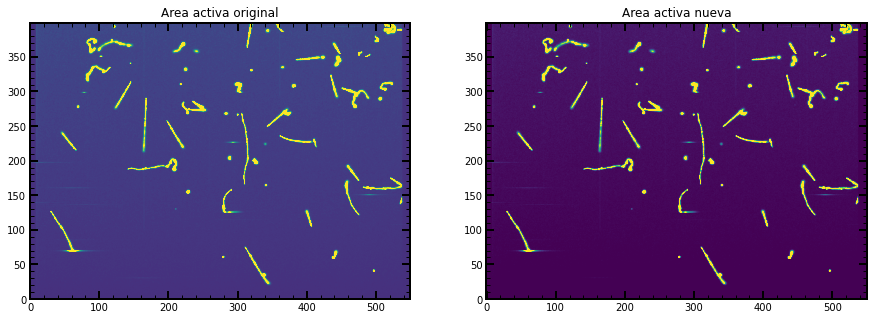

In [11]:
## Se muestra la comparación de la extensión original y despues de quitarle la mediana

Figsize = [15,15]
fig, axs = plt.subplots(1, 2, figsize=Figsize)
# oScan_mask=sk.measure.label(Overscan>=np.max(Overscan) , connectivity=2)
# oScan=ma.masked_array(Overscan,mask=(oScan_mask>0))
Vmin = 1000
Vmax = 100000
axs[0].set_title('Area activa original')
axs[1].set_title('Area activa nueva')
x0 = axs[0].imshow(active_area, origin='lower', vmin=Vmin, vmax = Vmax)
x1 = axs[1].imshow(true_active_area, origin='lower', vmin=Vmin, vmax = Vmax)
# plt.colorbar()

# fig.colorbar(x0, ax=axs[0]) 
# fig.colorbar(x1, ax=axs[1])

print(active_area.max())
print(true_active_area.max())
plt.show()

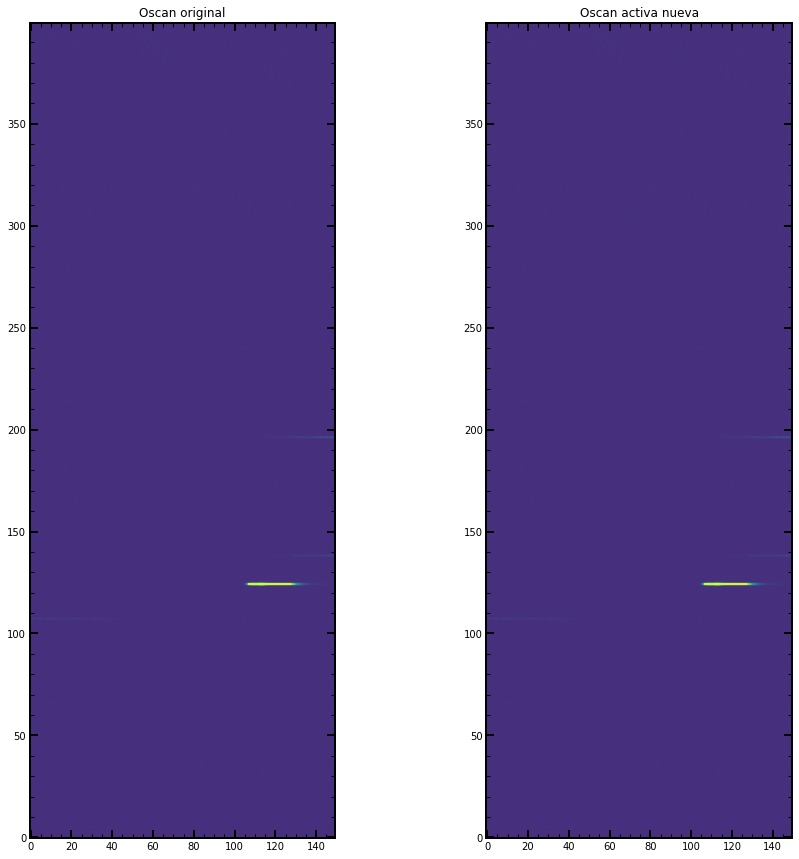

In [12]:
fig, axs = plt.subplots(1, 2, figsize=Figsize)
# oScan_mask=sk.measure.label(Overscan>=np.max(Overscan) , connectivity=2)
# oScan=ma.masked_array(Overscan,mask=(oScan_mask>0))
Vmin = 1000
Vmax = 100000
axs[0].set_title('Oscan original')
axs[1].set_title('Oscan activa nueva')
x0 = axs[0].imshow(Overscan, origin='lower', vmin=Vmin, vmax = Vmax)
x1 = axs[1].imshow(true_Oscan, origin='lower', vmin=Vmin, vmax = Vmax)
# plt.colorbar()

# fig.colorbar(x0, ax=axs[0]) 
# fig.colorbar(x1, ax=axs[1])

# print(active_area.max())
# print(true_active_area.max())
plt.show()

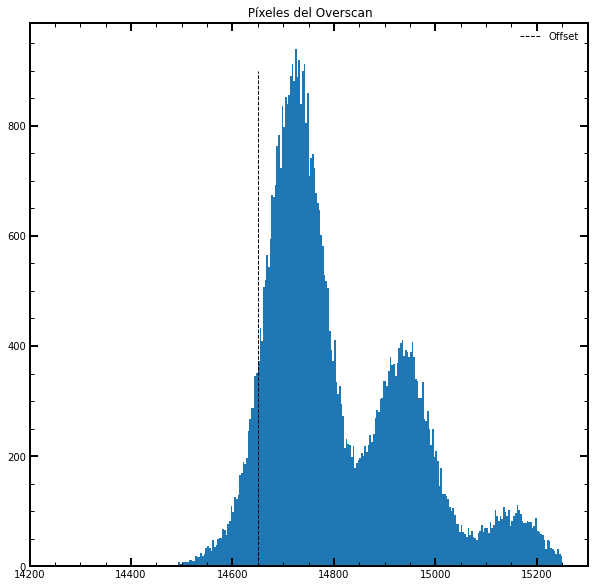

In [13]:
fig_all, axs_all = plt.subplots(1, 1, figsize=(10, 10))

min_oScan = np.min(true_Oscan)

## Generamos el histograma de los pixeles del oScan especificando el rango
bin_heights, bin_borders, _ = axs_all.hist(true_Oscan.flatten(), bins= 300, range = (14250, 15250))# , label="Pixeles del Overscan")
axs_all.vlines(14651.275, ymin=0, ymax=900, colors='k', linestyle = 'dashed', label = 'Offset')
# axs_all.vlines(14720.0, ymin=0, ymax=2000, colors='r')

axs_all.set_title(' Píxeles del Overscan')
plt.legend()

plt.show()

In [14]:
### Se obtiene el offset del overscan

# extension = 4
Bins = 300
ratio_keV = 0.0037  ## KeV/e-

# data = hdu_list[extension-1].data[:, :550]
data = true_active_area
header = hdu_list[extension-1].header
# oScan=hdu_list[extension-1].data[:,550:]

nsamp = float(header['NSAMP'])
# expgain = [227, 220.4, 94.72, 197.7]
expgain = [227, 220.4, 94.72, 200] ## e-/ADUs

#Aplanar la imágen
hist , bins_edges = np.histogram(true_Oscan.flatten(), bins = Bins, range=(min_oScan, 18000))
offset = bins_edges[np.argmax(hist)]
print('Offset: ', offset)


Overscan_plane = true_Oscan - offset

Offset:  14721.842


 Centroide:  1.9984290532584386 Sigma:  57.03210913859944 Ganancia:  213.76047595287784  en ADUs


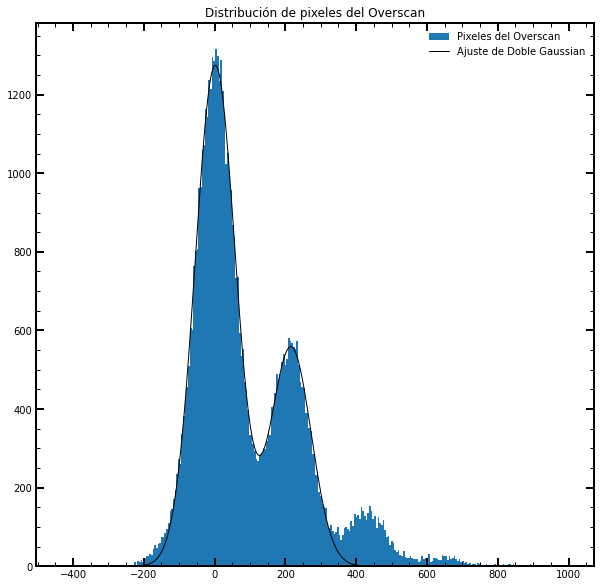

In [15]:
fig_all, axs_all = plt.subplots(1, 1, figsize=(10, 10))

min_oScan_plane = np.min(Overscan_plane)

## Generamos el histograma de los pixeles del oScan especificando el rango
bin_heights, bin_borders, _ = axs_all.hist(Overscan_plane.flatten(), bins= Bins, range = (min_oScan_plane, 1000) , label="Pixeles del Overscan")

## Generamos los bins y las alturas
bin_centers = np.zeros(len(bin_heights), dtype=float)
offset_fit = bin_borders[np.argmax(bin_heights)]

for p in range(len(bin_heights)):
    bin_centers[p]=(bin_borders[p+1]+bin_borders[p])/2

# print(bin_centers[0], bin_centers[-1])

# xmin_fit, xmax_fit = offset_fit - (10 * expgain[extension-1])/math.sqrt(nsamp), offset_fit + (10 * expgain[extension-1])/math.sqrt(nsamp)			# Define fit range
# xmin_fit, xmax_fit = -abs(offset_fit), abs(offset_fit)
xmin_fit, xmax_fit = bin_centers[0], bin_centers[-1]
# print(xmin_fit, xmax_fit)

bin_heights = bin_heights[(bin_centers>xmin_fit) & (bin_centers<xmax_fit)]
bin_centers = bin_centers[(bin_centers>xmin_fit) & (bin_centers<xmax_fit)]


###### ----------------- Ajustanto la gaussiana doble ------------------ ######
## gaussian2(x,m,s,g,a1,a2): #data, popt (mean, sigma, gain, height1, heigth2)
popt, _ = curve_fit(Gaussian2, bin_centers, bin_heights, maxfev=50000, p0 = [300,70, 200, 900, 200])
axs_all.plot(bin_centers, Gaussian2(bin_centers, *popt), 'k', label = 'Ajuste de Doble Gaussian')
print(' Centroide: ', popt[0], 'Sigma: ', popt[1], 'Ganancia: ', popt[2], ' en ADUs')


###### ----------------- Ajustanto una gaussiana ------------------ ######
## gaussian(x, a, mean, sigma)
# popt,_ = curve_fit(gaussian, bin_centers, bin_heights, maxfev=10000, p0 = [900,300,70])
# axs_all.plot(bin_centers, gaussian(bin_centers, *popt),'k', label = 'Gaussian fit')
# print(' Amplitud: ', popt[0], 'Centroide: ', popt[1], 'sigma: ', popt[2]) #gaussian(x, a, mean, sigma)


# axs_all.plot(bin_centers, bin_heights, 'k')
# print(len(bin_centers))
# print(len(bin_heights))

# plt.xlim(-1,1)
# plt.yscale('log')
# plt.ylim(10**(0), 10**(6))
# plt.xlim(-50,50)
# plt.ylim(0, 100)
# axs_all.set_yscale('log')
axs_all.set_title("Distribución de pixeles del Overscan")
axs_all.legend()
plt.show()

# n_events
# print(popt)
# dataP
# print(header['RUNID'])

In [16]:
##### Sigma en e- ####
sig_ADUs = popt[1]
Gain = popt[2]

sig_elec = abs(( sig_ADUs) / Gain)
print('Sigma: ', sig_elec, ' e-')

Sigma:  0.2668038087226743  e-


In [17]:
min_energy_for_label = 4 * sig_elec
# min_energy_for_label = 200 * sig_elec


list_Runid = []
list_ext = []
list_Matrix_Slice_Event = []
list_Size_Matrix_Event = []
#Listas a mano
list_event_size = []
list_charge = []
list_mean_charge = []
list_Barycenter= []
list_Barycenter_charge = []
list_n_events = []

#Listas skmeasure
list_event_size_sk = []
list_mean_charge_sk = []
list_Barycenter_sk= []
list_Barycenter_charge_sk = []
list_n_events_sk = []

# dataCal = true_active_area #### NO ESTÁN CALIBRADOS; SOLO SE USÓ LA VARIABLE PARA NO CAMBIAR TODO EL CÓDIGO 
# min_energy_for_label = 150 * abs(popt[2])


# # extension = extension ## Extension's number
# extra = 0
# # data = hdu_list[extension-1].data
# header = hdu_list[extension-1].header
Runid = str(int(header['RUNID']))

# oScan=hdu_list[extension-1].data[:,530:]
# expgain = [227, 220.4, 94.72, 197.7]

# hist , bins_edges = np.histogram(oScan.flatten(), bins = 1000000)
# offset = bins_edges[np.argmax(hist)]

dataP = true_active_area - offset ## Datos aplanados en ADUs
dataCal = (dataP)/Gain ## Datos planos en e-


# label, n_events =ndimage.label(dataCal>6*abs(popt[2]),structure=[[1,1,1],[1,1,1],[1,1,1]])
# label, n_events =ndimage.label(dataCal>6*abs(popt[2]),structure=[[1,0,1],[1,1,1],[1,0,1]])
# label, n_events =ndimage.label(dataCal>6*abs(popt[2]),structure=[[0,1,0],[1,1,1],[0,1,0]])
label_img, nlabels_img = sk.measure.label(dataCal> min_energy_for_label, connectivity=2, return_num=True)

prop = sk.measure.regionprops(label_img,dataCal)

## Obteniendo el valor promedio del fondo
# fondo_mask = np.invert(label==0)
fondo_mask = np.invert(label_img==0)
fondo = ma.masked_array(dataCal,fondo_mask)
# print(fondo)
valor_promedio_fondo = fondo.data.mean()
# print(valor_promedio_fondo)
# plt.imshow(fondo, cmap='gray')
# plt.colorbar()


for i in range(0,nlabels_img):
    list_n_events.append(i+1)

for event in range(1, nlabels_img+1):
    mask = np.invert(label_img == event)
    loc = ndimage.find_objects(label_img == event)[0]
    
    data_maskEvent = ma.masked_array(dataCal[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop],
                                         mask[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop])
    if len(data_maskEvent)<1:
        list_Size_Matrix_Event.append('NaN')

    else:
        ## Número de imagen
        list_Runid.append(Runid)

        ## Número de Extensión
        list_ext.append(extension)

        ## Lista de Coordenadas de cada evento
        list_Size_Matrix_Event.append(str(data_maskEvent.shape[1])+'x'+str(data_maskEvent.shape[0])) ## La dimensión de la matriz del evento en pixeles
        
        event_size = 0
        # Obtiene los pixeles que componen al evento(a mano)
        # for i in range(0,len(data_maskEvent.flatten())):
        #     if data_maskEvent.flatten()[i]:
        #         event_size = event_size+1
        # list_event_size.append(int(event_size))

        # Obtiene los pixeles que componen al evento(con skmeasure)
        # try:
        num_pixels = prop[event-1].num_pixels
        list_event_size_sk.append(num_pixels)
        # except:
        #     list_event_size_sk.append('NaN')

        # Obtiene la carga total del evento en electrones
        # charge = 0
        # for i in data_maskEvent.data.flatten():
        #     if i >= valor_promedio_fondo:
        #         charge = charge + i
        charge = data_maskEvent.sum()
        # list_charge.append(data_maskEvent.sum())
        list_charge.append(charge)

        # Carga promedio en electrones (a mano)
        # try:
        #     mean_charge = charge/event_size
        #     list_mean_charge.append(round(mean_charge,3))
        # except:
        #     # list_mean_charge.append('None Event Size')
        #     continue

        mean_ch = prop[event-1].intensity_mean
        list_mean_charge_sk.append(round(mean_ch,3))
        

        ## Baricentro (a mano)
        # centerCharge = ndimage.center_of_mass(data[1][loc])
        # coordX_centerCharge = round(ndimage.center_of_mass(data_maskEvent)[1],4)
        # coordY_centerCharge = round(ndimage.center_of_mass(data_maskEvent)[0],4)
        # list_coordCenterCharge = [coordX_centerCharge, coordY_centerCharge]
        # list_Barycenter.append(list_coordCenterCharge)
        # print(centerMass)

        ## Baricentro (con skmeasure)
        coordY_centerCharge, coordX_centerCharge = round(prop[event-1].centroid_local[0],4), round(prop[event-1].centroid_local[1],4)
        list_coordCenterCharge = [coordX_centerCharge, coordY_centerCharge]
        # print('Barycenter: ', prop[n_label-1].centroid_local)
        list_Barycenter_sk.append(list_coordCenterCharge)
        # print(centerMass)


        ## Carga del Baricentro (a mano)
        # coordX_centerCharge = round(ndimage.center_of_mass(data_maskEvent)[1])
        # coordY_centerCharge = round(ndimage.center_of_mass(data_maskEvent)[0])
        # BarycenterChage = data_maskEvent[coordY_centerCharge, coordX_centerCharge]
        
        # if BarycenterChage:
        #     list_Barycenter_charge.append(BarycenterChage)
        # else: 
        #     list_Barycenter_charge.append('NaN')

        ## Carga del Baricentro (con skmeasure)
        BarycenterChage = prop[event-1].centroid_weighted_local
        # if BarycenterChage:
        list_Barycenter_charge_sk.append(BarycenterChage)
        # else: 
        #     list_Barycenter_charge_sk.append('NaN')
        # list_centerCharge.append(centerCharge)
        # print(list_centerCharge)

## DataFrame de Cada evento
print('Events: '+ str(list_n_events[-1]))
RunidFrame = pd.DataFrame(list_Runid, columns = ['Image ID'])
ExtensionFrame = pd.DataFrame(list_ext, columns = ['Extension'])
Event_IDFrame= pd.DataFrame(list_n_events, columns = ['Event ID'])
Matrix_Size_EventFrame = pd.DataFrame(list_Size_Matrix_Event, columns = ['Matrix Size (px)'])

# Event_SizeFrame = pd.DataFrame(list_event_size, columns = ['Event Size (px)'])
EventSK_SizeFrame = pd.DataFrame(list_event_size_sk, columns = ['Event Size SK (px)'])

ChargeFrame = pd.DataFrame(list_charge, columns = ['Total Charge (keV)'])

# MeanChargeFrame = pd.DataFrame(list_mean_charge, columns = ['Mean Charge (keV)'])
MeanChargeSKFrame = pd.DataFrame(list_mean_charge_sk, columns = ['Mean Charge SK (keV)'])


# totalFrame =pd.concat([Event_IDFrame,RunidFrame, ExtensionFrame, Matrix_Size_EventFrame, Event_SizeFrame, EventSK_SizeFrame, ChargeFrame, MeanChargeFrame, MeanChargeSKFrame], axis = 1 )
totalFrame = pd.concat([Event_IDFrame, RunidFrame, ExtensionFrame, Matrix_Size_EventFrame, EventSK_SizeFrame, ChargeFrame, MeanChargeSKFrame], axis = 1 )

# totalFrame['Barycenter (px)']=pd.Series(list_Barycenter)
totalFrame['Barycenter_SK (px)']=pd.Series(list_Barycenter_sk)

# totalFrame["Barycenter Charge (keV)"]=pd.Series(list_Barycenter_charge)
# totalFrame["Barycenter Charge SK (e-)"]=pd.Series(list_Barycenter_charge_sk)


TF = totalFrame.set_index('Event ID')
TF
# TF.query('Event Size (px) >= 200')
# totalFrame.style.hide_index()

Events: 85


,Image ID,Extension,Matrix Size (px),Event Size SK (px),Total Charge (keV),Mean Charge SK (keV),Barycenter_SK (px)
Event ID,,,,,,,
1,32,1,37x55,246,136993.906250,556.885986,"[20.1463, 21.5407]"
2,32,1,3x3,7,11371.599609,1624.514038,"[1.0, 0.7143]"
3,32,1,9x13,68,85166.937500,1252.454956,"[3.9706, 6.2059]"
4,32,1,3x3,8,18528.138672,2316.017090,"[0.875, 1.125]"
5,32,1,58x58,249,137468.875000,552.083984,"[22.498, 20.0683]"
...,...,...,...,...,...,...,...
81,32,1,5x1,5,19.953493,3.991000,"[2.0, 0.0]"
82,32,1,2x1,2,27.277573,13.639000,"[0.5, 0.0]"
83,32,1,1x1,1,2.762004,2.762000,"[0.0, 0.0]"


Event Slice:
x: [495,498]
y: [40,43]


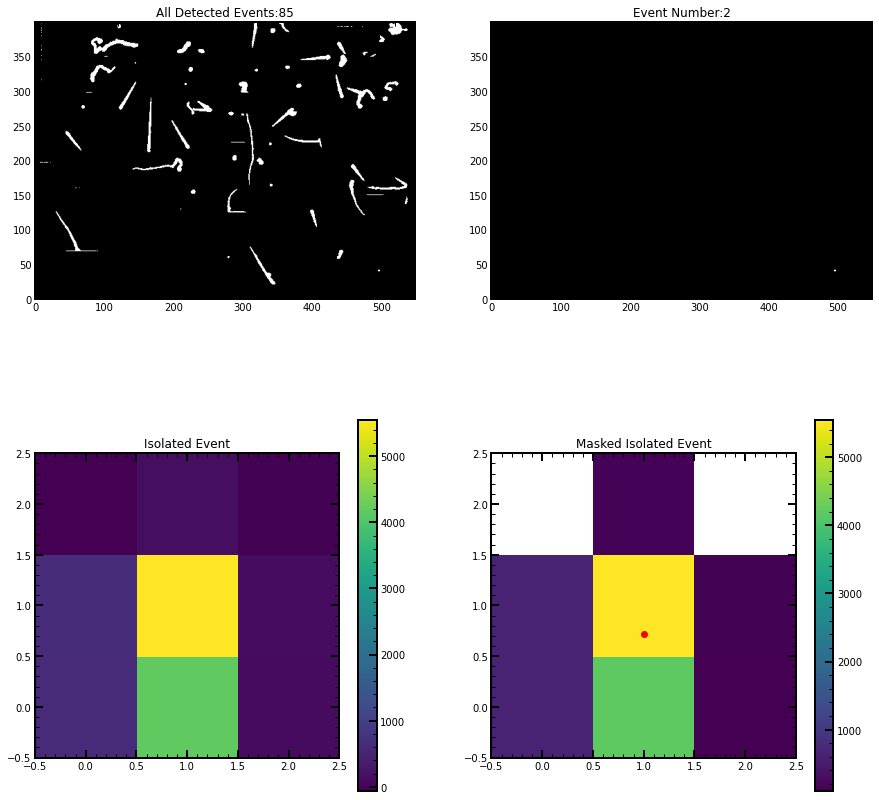

Event Slice:
x: [495,498]
y: [40,43]


,Image ID,Extension,Matrix Size (px),Event Size SK (px),Total Charge (keV),Mean Charge SK (keV),Barycenter_SK (px)
Event ID,,,,,,,
2,32,1,3x3,7,11371.599609,1624.514038,"[1.0, 0.7143]"


In [18]:
n_label = 2
extra = 0


label, n_events = ndimage.label(dataCal > min_energy_for_label,structure=[[1,1,1],[1,1,1],[1,1,1]]) # 48
# label, n_events = ndimage.label(dataCal>6*abs(popt[2]),structure=[[0,1,0],[1,1,1],[0,1,0]]) ## 50, 52
loc = ndimage.find_objects(label==n_label)[0]

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15,15))
# fig.suptitle('Event Number '+ str(n_label))
## Imagen original
axs[0,0].set_title('All Detected Events:'+str(n_events))
axs[0,0].imshow(label==0, cmap='gist_yarg', vmax=1, vmin=0, origin='lower')
# plt.suptitle('Primer Imagen')

## Evento en la imagen original
axs[0,1].set_title('Event Number:'+str(n_label))
axs[0,1].imshow(label==n_label, cmap='gray', vmax=1,vmin=0, origin='lower')


axs[1,0].set_title('Isolated Event')
x1 = axs[1,0].imshow(dataCal[loc[0].start-extra:loc[0].stop+extra, loc[1].start-extra:loc[1].stop+extra], cmap='viridis', origin = 'lower')
# plt.colorbar()

mask_35 = np.invert(label==n_label)
data_mask = ma.masked_array(dataCal[loc[0].start-extra:loc[0].stop+extra, loc[1].start-extra:loc[1].stop+extra], mask_35[loc[0].start-extra:loc[0].stop+extra, loc[1].start-extra:loc[1].stop+extra])
axs[1,1].set_title('Masked Isolated Event')
x2 = axs[1,1].imshow(data_mask, cmap='viridis', origin='lower')
axs[1,1].plot(totalFrame.iat[n_label-1, 7][0], totalFrame.iat[n_label-1, 7][1], 'ro') ## Plot the baricentrum
# print('n_label:', n_label)
# plt.legend('Baricentrum')

fig.colorbar(x1, ax=axs[1,0])
fig.colorbar(x2, ax=axs[1,1])
# fig.colorbar(axs[1,1], ax=[[x1,x2]], location = 'bottom', fraction = .1)

print('Event Slice:'  )
print('x: ['+str(loc[1].start)+','+str(loc[1].stop)+']')
print('y: ['+str(loc[0].start)+','+str(loc[0].stop)+']')
# print(loc)
# print(totalFrame.set_index('Event ID').iloc[[n_label-1]])
plt.show()
totalFrame.set_index('Event ID').iloc[[n_label-1]]
# plt.suptitle('Primer Imagen')

## Evento en la imagen original
axs[0,1].set_title('Event Number:'+str(n_label))
axs[0,1].imshow(label==n_label, cmap='gray', vmax=1,vmin=0, origin='lower')


axs[1,0].set_title('Isolated Event')
x1 = axs[1,0].imshow(dataCal[loc[0].start-extra:loc[0].stop+extra, loc[1].start-extra:loc[1].stop+extra], cmap='viridis', origin = 'lower')
# plt.colorbar()

mask_35 = np.invert(label==n_label)
data_mask = ma.masked_array(dataCal[loc[0].start-extra:loc[0].stop+extra, loc[1].start-extra:loc[1].stop+extra], mask_35[loc[0].start-extra:loc[0].stop+extra, loc[1].start-extra:loc[1].stop+extra])
axs[1,1].set_title('Masked Isolated Event')
x2 = axs[1,1].imshow(data_mask, cmap='viridis', origin='lower')
axs[1,1].plot(totalFrame.iat[n_label-1, 7][0], totalFrame.iat[n_label-1, 7][1], 'ro') ## Plot the baricentrum
# print('n_label:', n_label)
# plt.legend('Baricentrum')

fig.colorbar(x1, ax=axs[1,0])
fig.colorbar(x2, ax=axs[1,1])
# fig.colorbar(axs[1,1], ax=[[x1,x2]], location = 'bottom', fraction = .1)

print('Event Slice:'  )
print('x: ['+str(loc[1].start)+','+str(loc[1].stop)+']')
print('y: ['+str(loc[0].start)+','+str(loc[0].stop)+']')
# print(loc)
# print(totalFrame.set_index('Event ID').iloc[[n_label-1]])
plt.show()
totalFrame.set_index('Event ID').iloc[[n_label-1]]

Centroide:  (64.20588235294117, 439.97058823529414)
Radio mayor:  15.671989594106488
Radio menor:  5.804885928226897
Box:  (58, 436, 71, 445)
Centroid Weighted:  (61.84902132889651, 438.83568530693935)
Label:  3
Orientation:  0.41848086930017797
Slice:  (slice(58, 71, None), slice(436, 445, None))
Eccentricity:  0.9288728324880169
Solidity:  0.8717948717948718
Barycenter:  [6.20588235 3.97058824]


Event Charge:  85166.94  keV
Local Box:  [9, 13]  px
Local Box:  [135, 195] micras
Diagonal Lenght:  14.3971747384688  px
Diagonal Lenght:  215.957621077032  micras
Delta_L:  725.1429366962419  px
Delta_L:  10877.144050443629  micras
Delta EL:  117.44848248542746  keV/px
Delta EL:  7.829898832361831  keV/micras
Delta EL:  1174484.8248542745  keV/cm


(435.0, 446.0, 57.0, 72.0)

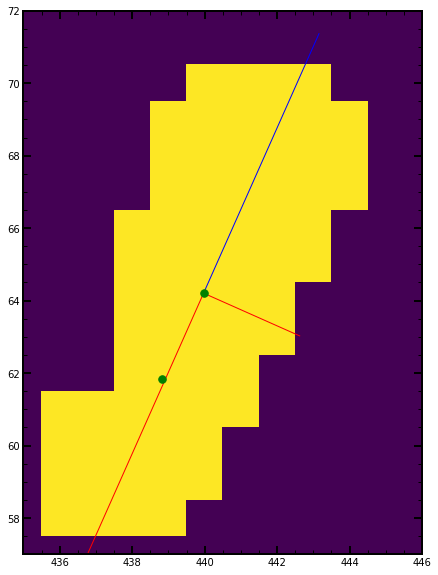

In [19]:
### Esta celda tiene el proceso para ir obteniendo las propiedadesd de un evento con la librería Scikit-Image

n_label= 3
CCD_depth = 725 ## micras
px_to_micras = 15 ## micras
px_to_cm = 0.0015 ## cm/px
micra_to_cm = 1 / 10000 ## micras/cm
fig, ax = plt.subplots(figsize=(10,10))

label_img, nlabels_img = sk.measure.label(dataCal > min_energy_for_label, connectivity=2, return_num=True)
# print(nlabels_img)
ax.imshow(label_img==n_label) # Matriz centrada en el origen

prop = sk.measure.regionprops(label_img,dataCal)
# prop = sk.measure.regionprops(label_img)

# loc = ndimage.find_objects(label==n_label)[0]
loc = prop[n_label-1].slice

mask_35 = np.invert(label_img==n_label)
# ax.imshow(dataCal[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop])

data_mask = ma.masked_array(dataCal[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop], mask_35[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop])
charge = data_mask.sum()
# plt.imshow(dataCal[maxim.start:maxim.stop])
# ax.imshow(data_mask)


print("Centroide: ", prop[n_label-1].centroid)
print("Radio mayor: ", prop[n_label-1].axis_major_length)
print("Radio menor: ", prop[n_label-1].axis_minor_length)
print("Box: ", prop[n_label-1].bbox)
# print("Centroide Local: ", prop[n_label-1].centroid_local)
print('Centroid Weighted: ', prop[n_label-1].centroid_weighted)
# print(prop[n_label-1].centroid_weighted_local)
# print(prop[n_label-1].coords_scaled)
# print(prop[n_label-1].coords)
# print(prop[n_label-1].extent)
# print(prop[n_label-1].image)
# print(prop[n_label-1].image_intensity)
print('Label: ', prop[n_label-1].label)
print('Orientation: ', prop[n_label-1].orientation)
print('Slice: ', prop[n_label-1].slice)
print('Eccentricity: ', prop[n_label-1].eccentricity)
print('Solidity: ', prop[n_label-1].solidity)
print('Barycenter: ', prop[n_label-1].centroid_local)
# print('Inertia tensor: ', prop[n_label-1].inertia_tensor)
# print('Intensity Max: ', prop[n_label-1].intensity_max)

print('\n')
## Ellipse 
y0, x0 = prop[n_label-1].centroid
# y0, x0 = prop[n_label-1].centroid_weighted

orientation = prop[n_label-1].orientation
rotation = orientation*1
x1 = x0 + math.cos(orientation) * 0.5 * prop[n_label-1].axis_minor_length
y1 = y0 - math.sin(orientation) * 0.5 * prop[n_label-1].axis_minor_length

x2 = x0 - math.sin(orientation) * 0.5 * prop[n_label-1].axis_major_length
y2 = y0 - math.cos(orientation) * 0.5 * prop[n_label-1].axis_major_length # Ellipse's major radio

x3 = x0 - math.sin(-orientation) * 0.5 * prop[n_label-1].axis_major_length
y3 = y0 + math.cos(orientation) * 0.5 * prop[n_label-1].axis_major_length # Ellipse's major radio


ax.plot((x0, x1), (y0, y1), 'r', linewidth=1)
ax.plot((x0, x3), (y0, y3), 'b', linewidth=1)
ax.plot((x0, x2), (y0, y2), 'r', linewidth=1)

ax.plot(x0, y0, '.g', markersize=15) # Ellipse's center
ax.plot(prop[n_label-1].centroid_weighted[1], prop[n_label-1].centroid_weighted[0], '.g', markersize=15)

## Box and Delta_L
miny, minx, maxy, maxx = prop[n_label-1].bbox
Longitud_y = maxy - miny # px
Longitud_x = maxx - minx # px
Diagonal_lenght= np.sqrt(Longitud_x**2 + Longitud_y**2) - np.sqrt(2) # px
Delta_L = np.sqrt(Diagonal_lenght**2 + CCD_depth**2) # px
DeltaEL = charge / Delta_L # keV/px

print('Event Charge: ', charge, ' keV')
print("Local Box: ", [Longitud_x, Longitud_y], ' px' )
print("Local Box: ", [Longitud_x * px_to_micras, Longitud_y * px_to_micras], 'micras' )
print('Diagonal Lenght: ', Diagonal_lenght, ' px') ## px
print('Diagonal Lenght: ', Diagonal_lenght * px_to_micras, ' micras')
print('Delta_L: ', Delta_L, ' px')
print('Delta_L: ', Delta_L * px_to_micras, ' micras')
print('Delta EL: ', DeltaEL, ' keV/px')
print('Delta EL: ', DeltaEL / px_to_micras, ' keV/micras')
print('Delta EL: ', DeltaEL / micra_to_cm, ' keV/cm')
bx = (minx, maxx, maxx, minx, minx)
by = (miny, miny, maxy, maxy, miny)
# ax.plot(bx, by, '-b', linewidth=2.5)


# excent = prop[n_label-1].eccentricity
u= x0   #x-position of the center
v= y0    #y-position of the center
b = prop[n_label-1].axis_major_length    #radius on the x-axis
a = prop[n_label-1].axis_minor_length   #radius on the y-axis

ext=1
ax.axis((loc[1].start-ext, loc[1].stop+ext, loc[0].start-ext, loc[0].stop+ext))
# ax.imshow(data_mask)
# ax.can_zoom()

In [20]:
## Calcula cuantos eventos rectos tiene la extensión comparando la relación del radio mayor de la elipse con el radio menor
Straight_Events = []
DeltaEL_range_min, DeltaEL_range_max = 1, 3.55
prop = sk.measure.regionprops(label_img, dataCal)

for event in range(1, nlabels_img):

    mask = np.invert(label_img == event)
    loc = ndimage.find_objects(label_img == event)[0]
    
    data_maskEvent = ma.masked_array(dataCal[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop],
                                         mask[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop])

    coordX_centerCharge = round(ndimage.center_of_mass(data_maskEvent)[1])
    coordY_centerCharge = round(ndimage.center_of_mass(data_maskEvent)[0])

    coordY_centerCharge, coordX_centerCharge = int(prop[event-1].centroid_local[0]), int(prop[event-1].centroid_local[1])
    # print(type(coordY_centerCharge))
    # MaxValue_Event = data_maskEvent.max()
    MinValue_Event = data_maskEvent.min()
    MeanValue_Event = data_maskEvent.mean()
    # MeanValue_Event = (MaxValue_Event - MinValue_Event)/2
    Barycentercharge = data_maskEvent[coordY_centerCharge, coordX_centerCharge]
    try:
        differval = abs(Barycentercharge - MinValue_Event) 
    except:
        differval = 0 

    rM = prop[event-1].axis_major_length
    rm = prop[event-1].axis_minor_length
    Solidity = prop[event-1].solidity
    miny, minx, maxy, maxx = prop[event-1].bbox
    Longitud_y, Longitud_x = maxy - miny , maxx - minx # px
    Diagonal_lenght= np.sqrt(Longitud_x**2 + Longitud_y**2) - np.sqrt(2) # px
    Delta_L = np.sqrt( (Diagonal_lenght * px_to_micras)**2 + (CCD_depth)**2) # micras

    if rM == 0 or rm == 0:
        continue 

    elif maxx - minx <= 3:
        continue

    elif not Barycentercharge:
        continue

    elif differval < MeanValue_Event: #keV
        continue

    elif  Solidity < 0.7:
        continue 
        # Straight_Events.append(event)

    elif  rM > 4.5 * rm:
        charge = data_maskEvent.sum()
        DeltaEL = (charge/1000 )/ (Delta_L * micra_to_cm) #MeV/cm
        # print(charge, DeltaEL)

        # if DeltaEL_range_min <= DeltaEL <= DeltaEL_range_max:
            # print(charge)
        Straight_Events.append(event)


print('Muons Detected: ', len(Straight_Events))
print(Straight_Events)

Muons Detected:  8
[7, 20, 27, 29, 37, 41, 55, 65]


In [21]:
## Calcular el dE/dL de cada evento detectado
label_img, nlabels_img = sk.measure.label(dataCal > min_energy_for_label, connectivity=2, return_num=True)
prop = sk.measure.regionprops(label_img,dataCal)
list_dedl = []
list_diagonal_lenght = []
list_dl = []
list_charge = []
list_angle = []

for index_event in range(0,len(Straight_Events)):
    mask = np.invert(label_img == Straight_Events[index_event])
    loc = ndimage.find_objects(label_img == Straight_Events[index_event])[0]
    
    data_maskEvent = ma.masked_array(dataCal[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop],
                                         mask[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop])

    charge = data_maskEvent.sum() 
    miny, minx, maxy, maxx = prop[Straight_Events[index_event]-1].bbox
    Longitud_y = maxy - miny # px
    Longitud_x = maxx - minx # px
    Diagonal_lenght= np.sqrt(Longitud_x**2 + Longitud_y**2) - np.sqrt(2) # px
    Delta_L = np.sqrt( (Diagonal_lenght * px_to_micras)**2 + (CCD_depth)**2) * micra_to_cm # cm
    DeltaEL_KeV= charge / (Delta_L) # keV/cm
    DeltaEL_MeV= (charge / 1000) / (Delta_L) # MeV/cm
    theta = np.arctan((Diagonal_lenght * px_to_cm)/(CCD_depth * micra_to_cm)) *(180 /np.pi)

    list_diagonal_lenght.append(Diagonal_lenght * px_to_cm)
    list_dl.append(Delta_L)
    list_charge.append(charge/1000)
    list_dedl.append(DeltaEL_MeV)
    list_angle.append(theta)
    # print(Straight_Events[index_event], str(DeltaEL_GeV) + ' GeV/cm')
    # print( Straight_Events[index_event], Delta_L, DeltaEL_MeV, charge, theta)

DF_straightevents = pd.DataFrame(Straight_Events, columns=['Event ID'] )
DF_diagonal_lenght = pd.DataFrame(list_diagonal_lenght, columns=['Diagonal XY (cm)'])
DF_dl = pd.DataFrame(list_dl, columns=['Delta L (cm)'])
DF_charge = pd.DataFrame(list_charge, columns=['Charge (e-)'])
DF_dedl = pd.DataFrame(list_dedl, columns=['dE/dL (e-/cm)'])
DF_angle = pd.DataFrame(list_angle, columns=['Angle (°)'])
DF_dEdL = pd.concat([DF_straightevents, DF_diagonal_lenght, DF_dl, DF_charge,  DF_dedl, DF_angle], axis=1)
DF_dEdL.set_index('Event ID')

,Diagonal XY (cm),Delta L (cm),Charge (e-),dE/dL (e-/cm),Angle (°)
Event ID,,,,,
7,0.038267,0.081980,53.215660,649.133426,27.826276
20,0.044740,0.085194,61.889223,726.454696,31.678980
27,0.116843,0.137508,77.910641,566.588718,58.180773
29,0.071516,0.101837,76.126797,747.533667,44.608651
37,0.069910,0.100716,66.009555,655.404973,43.958049
41,0.051962,0.089198,59.679484,669.067058,35.629795
55,0.064961,0.097345,70.848164,727.801174,41.860655
65,0.055370,0.091225,68.225641,747.879359,37.369838


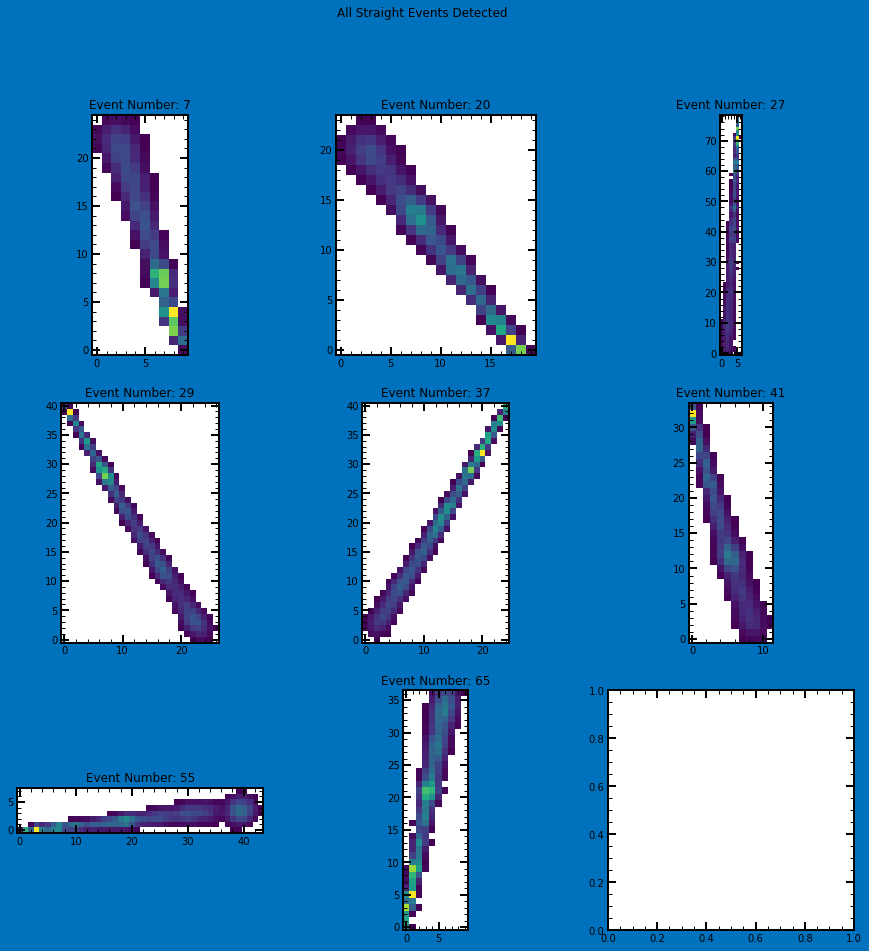

In [22]:
## Visualizar en una matriz los eventos rectos detectados 
coord2x2 = [[0,0],[0,1], [1,0], [1,1]]

coord3x3 = [[0,0],[0,1], [0,2], [1,0], [1,1], [1,2], [2,0], [2,1], [2,2]]

coord4x4 = [[0,0],[0,1], [0,2], [0,3], [1,0], [1,1], [1,2], [1,3], [2,0], [2,1], [2,2], [2,3], [3,0], [3,1], [3,2], [3,3]]

coords5x5 = [[0,0],[0,1], [0,2], [0,3], [0,4], [1,0], [1,1], [1,2], [1,3], [1,4], [2,0], [2,1], [2,2], [2,3], [2,4], [3,0], [3,1], [3,2], [3,3], [3,4],[4,0], [4,1], [4,2], [4,3], [4,4]]

if len(Straight_Events) < 5:
    fig, axs = plt.subplots(ncols = 2, nrows = 2, figsize=(15,15))
    fig.suptitle('All Muons Detected')

    for index_event in range(0,len(Straight_Events)):
        loc = ndimage.find_objects(label_img == Straight_Events[index_event])[0]
        mask_35 = np.invert(label_img == Straight_Events[index_event])
        data_mask = ma.masked_array(dataCal[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop], mask_35[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop])
        # plt.imshow(dataCal[maxim.start:maxim.stop])
        # ax.imshow(data_mask)

        axs[coord2x2[index_event][0],coord2x2[index_event][1]].set_title('Event Number: '+ str(Straight_Events[index_event]))
        # axs[coord2x2[index_event][0],coord2x2[index_event][1]].imshow(label_img == Straight_Events[index_event]) ## All image
        # axs[coord2x2[index_event][0],coord2x2[index_event][1]].imshow(dataCal[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop]) ## Event without mask
        axs[coord2x2[index_event][0],coord2x2[index_event][1]].imshow(data_mask) ## Event with mask
        # axs[coord2x2[index_event][0],coord2x2[index_event][1]].plot(TF.iat[Straight_Events[index_event]-1, 9][0], TF.iat[Straight_Events[index_event]-1, 9][1],  'ro')#[0], TF.iat[index_

elif len(Straight_Events) > 4 and len(Straight_Events) < 10:
    fig, axs = plt.subplots(ncols = 3, nrows = 3, figsize=(15,15), facecolor = [0, 0.4470, 0.7410])
    fig.suptitle('All Straight Events Detected')

    for index_event in range(0,len(Straight_Events)):
        loc = ndimage.find_objects(label_img == Straight_Events[index_event])[0]
        mask_35 = np.invert(label_img == Straight_Events[index_event])
        data_mask = ma.masked_array(dataCal[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop], mask_35[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop])
        # plt.imshow(dataCal[maxim.start:maxim.stop])
        # ax.imshow(data_mask)

        axs[coord3x3[index_event][0],coord3x3[index_event][1]].set_title('Event Number: '+ str(Straight_Events[index_event]))
        # axs[coord3x3[index_event][0],coord3x3[index_event][1]].imshow(label_img == Straight_Events[index_event]) ## All image
        # axs[coord3x3[index_event][0],coord3x3[index_event][1]].imshow(dataCal[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop]) ## Event without mask
        axs[coord3x3[index_event][0],coord3x3[index_event][1]].imshow(data_mask, aspect = 1) ## Event with mask
        # axs[coord3x3[index_event][0],coord3x3[index_event][1]].plot(TF.iat[Straight_Events[index_event]-1, 9][0], TF.iat[Straight_Events[index_event]-1, 9][1],  'ro')#[0], TF.iat[index_event, 7][1], 'ro') ## Plot the baricentrum

elif len(Straight_Events) > 9 and len(Straight_Events) < 17:
    fig, axs = plt.subplots(ncols = 4, nrows = 4, figsize=(15,15), facecolor = [0, 0.4470, 0.7410])
    fig.suptitle('All Straight Events Detected')

    for index_event in range(0,len(Straight_Events)):
        loc = ndimage.find_objects(label_img == Straight_Events[index_event])[0]
        mask_35 = np.invert(label_img == Straight_Events[index_event])
        data_mask = ma.masked_array(dataCal[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop], mask_35[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop])

        coordX_centerCharge = round(ndimage.center_of_mass(data_maskEvent)[1])
        coordY_centerCharge = round(ndimage.center_of_mass(data_maskEvent)[0])
        Barycentercharge = data_maskEvent[coordY_centerCharge, coordX_centerCharge]

        axs[coord4x4[index_event][0],coord4x4[index_event][1]].set_title('Event Number: '+ str(Straight_Events[index_event]))
        # axs[coord4x4[index_event][0],coord4x4[index_event][1]].imshow(label_img == Straight_Events[index_event]) ## All image
        # axs[coord4x4[index_event][0],coord4x4[index_event][1]].imshow(dataCal[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop]) ## Event without mask
        axs[coord4x4[index_event][0],coord4x4[index_event][1]].imshow(data_mask, aspect = 1) ## Event with mask
        # axs[coord4x4[index_event][0],coord4x4[index_event][1]].plot(TF.iat[Straight_Events[index_event]-1, 9][0], TF.iat[Straight_Events[index_event]-1, 9][1],  'ro')#[0], TF.iat[index_
        # axs[coord4x4[index_event][0],coord4x4[index_event][1]].text(1,0,'dE/dx', transform = axs[coord4x4[index_event][0],coord4x4[index_event][1]].transAxes)

elif len(Straight_Events) > 16 and len(Straight_Events) < 25:
    fig, axs = plt.subplots(ncols = 5, nrows = 5, figsize=(15,15))
    fig.suptitle('All Straight Events Detected')

    for index_event in range(0,len(Straight_Events)):
        loc = ndimage.find_objects(label_img == Straight_Events[index_event])[0]
        mask_35 = np.invert(label_img == Straight_Events[index_event])
        data_mask = ma.masked_array(dataCal[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop], mask_35[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop])
        # plt.imshow(dataCal[maxim.start:maxim.stop])
        # ax.imshow(data_mask)        

        axs[coords5x5[index_event][0],coords5x5[index_event][1]].set_title('Event Number: '+ str(Straight_Events[index_event]))
        axs[coords5x5[index_event][0],coords5x5[index_event][1]].imshow(label_img == Straight_Events[index_event])
        # axs[coords5x5[index_event][0],coords5x5[index_event][1]].imshow(dataCal[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop]) ## Event without mask
        axs[coords5x5[index_event][0],coords5x5[index_event][1]].imshow(data_mask) ## Event with mask

elif len(Straight_Events) > 25:
    print('Demasiados eventos para mostrar!!!')



# Con la imágen promedio